In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

2024-06-04 12:05:50.670187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 12:05:50.670308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 12:05:50.749822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Step 1: Define hierarchical structure from JSON
def extract_hierarchy(interests_json):
    hierarchy = {}
    for user in interests_json:
        for level1, level2_interests in user["interests"].items():
            if level1 not in hierarchy:
                hierarchy[level1] = set()
            for level2 in level2_interests:
                hierarchy[level1].add(level2)
    return hierarchy

In [3]:
import json

# Load interests JSON file
with open('/kaggle/input/input/users (1).json', 'r') as f:
    users = json.load(f)

hierarchy = extract_hierarchy(users)

print(hierarchy)
# Map hierarchical labels to integers
level1_to_int = {category: idx for idx, category in enumerate(hierarchy.keys())}
level2_to_int = {subcat: idx for idx, subcats in enumerate(hierarchy.values()) for subcat in subcats}
print("level 1 : ",level1_to_int)
print("level 2 : ",level2_to_int)

{'Business and Industry': {'Business', 'Health care', 'social media'}, 'family and relationships': {'parenting', 'family', 'dating and mariage'}, 'fitness and wellness': {'bodybuilding', 'running', 'yoga', 'Physical exercise'}, 'shopping and fashion': {'toys', 'fashion accessories', 'clothing', 'beauty', 'shopping'}, 'sports': {'basketball', 'golf', 'swimming', 'Auto racing', 'handball', 'baseball', 'volleyball', 'marathon', 'tennis', 'skiing', 'football/soccer', 'american football'}, 'Entertainment': {'movies', 'Games', 'live events', 'tv and series', 'music', 'reading'}, 'hobbies and activities': {'art and music', 'travel', 'political and socials issues', 'current event homes and garden', 'pets', 'vehicles'}, 'Technology': {'consumer electronics', 'computers'}, 'food and drink': {'beverages', 'cooking and cuisine', 'alcoholic beverage', 'food and restaurant'}, 'Outdoors': {'fishing', 'horseback riding', 'camping', 'hiking'}}
level 1 :  {'Business and Industry': 0, 'family and relatio

# Data Preprocessing

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [5]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [7]:
def concatenate_captions(posts):
    return ' '.join(post['caption'] for post in posts if post.get('caption'))

In [9]:
def replace_abbreviations(text, path):
    with open(path, 'r') as file:
        data = json.load(file)
    abbreviation_dict = data["abbreviation_dict"]
    words = text.split()
    replaced_words = [abbreviation_dict.get(word.upper(), word) for word in words]
    replaced_text = ' '.join(replaced_words)
    return replaced_text

In [10]:
import emoji
from bs4 import BeautifulSoup
import string
import re
X = []
Y_level1 = []
Y_level2 = []

for user in users:
    # Concatenate and preprocess captions
    concatenated_captions = concatenate_captions(user.get('posts', []))
    text = replace_abbreviations(concatenated_captions, "/kaggle/input/abreviations/abbreviations.json")
    preprocessed_text = text_preprocessing_pipeline(text)
        
    # Use the embedding (assuming you want to keep it) and add preprocessed text as well
    X.append(preprocessed_text)
        
    level1_labels = [0] * len(level1_to_int)
    level2_labels = [0] * len(level2_to_int)
        
    for level1, level2_interests in user["interests"].items():
        level1_idx = level1_to_int[level1]
        level1_labels[level1_idx] = 1
        for level2 in level2_interests:
            level2_idx = list(level2_to_int.keys()).index(level2)
            level2_labels[level2_idx] = 1
        
    Y_level1.append(level1_labels)
    Y_level2.append(level2_labels)

# Convert to numpy arrays for training
X = np.array(X)
Y_level1 = np.array(Y_level1)
Y_level2 = np.array(Y_level2)

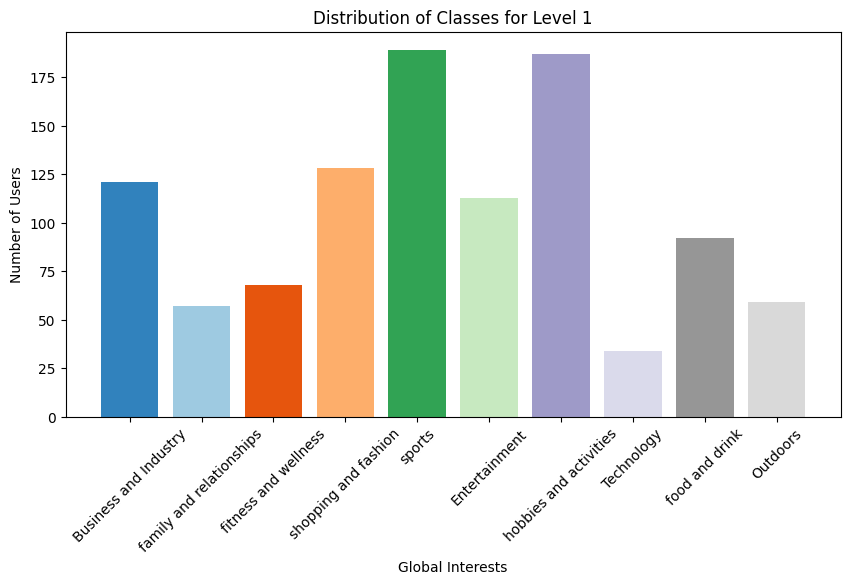

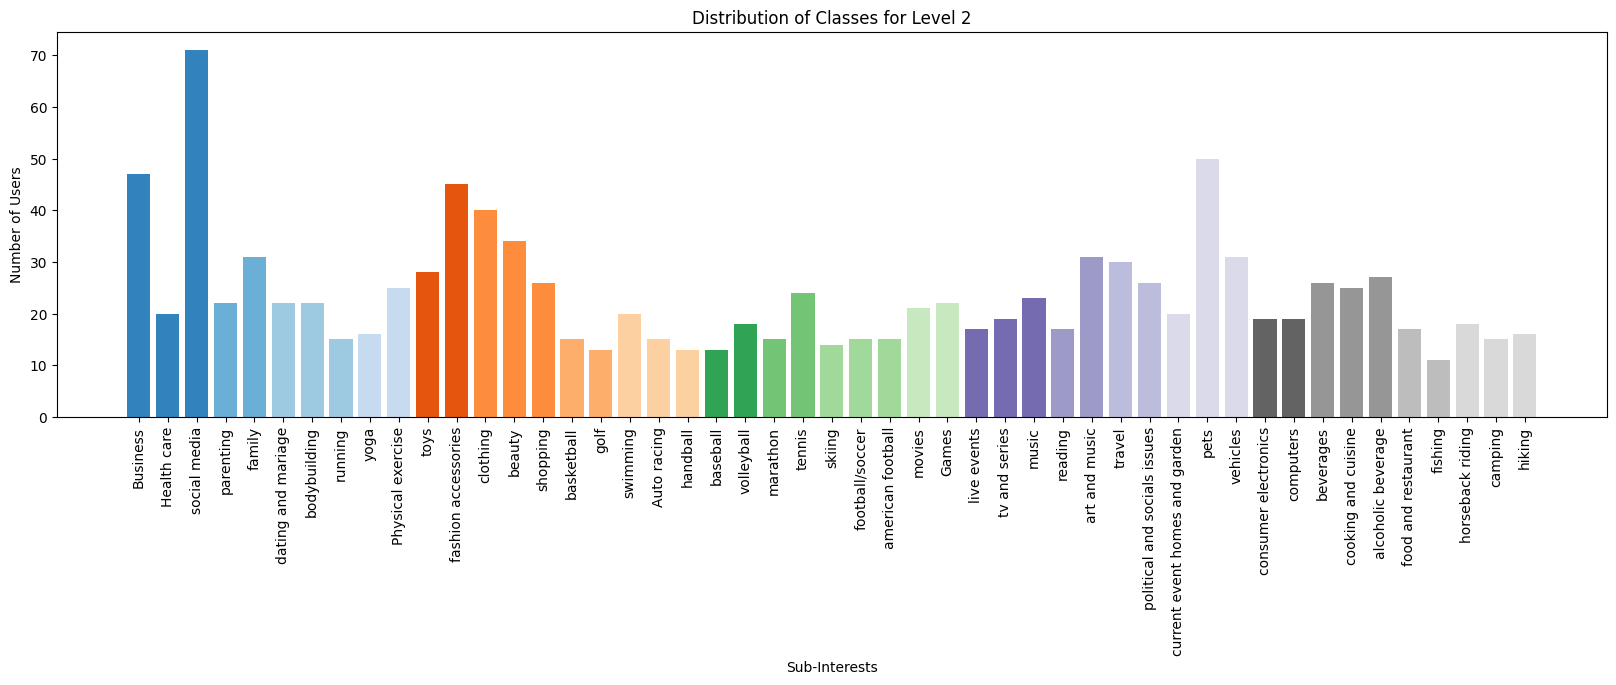

In [11]:
import matplotlib.pyplot as plt

# Plot distribution of classes for Level 1
plt.figure(figsize=(10, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, Y_level1.shape[1]))
plt.bar(level1_to_int.keys(), np.sum(Y_level1, axis=0), color=bar_colors)
plt.xlabel('Global Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 1')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of classes for Level 2
plt.figure(figsize=(20, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, Y_level2.shape[1]))
plt.bar(level2_to_int.keys(), np.sum(Y_level2, axis=0), color=bar_colors)
plt.xlabel('Sub-Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 2')
plt.xticks(rotation=90)
plt.show()


In [12]:
print(X[1])
print(Y_level1[1])
print(Y_level2[1])

happy birthday queen kourtneykardash there s no one on this planet that i have spent more time with and have all of the same memories with growing up than you and i cherish them all sharing a room and friends and cars and our lives together for four decades has been the most magical journey to have you by my side i love you and i can t wait for another years together i will especially cherish this last sister trip where all of our kids had dance parties today i learned they passed out the way we all did growing up celebrating you today and grateful to you forever for always giving the best advice a sister could possibly give we heard yousparklescamera with flashcamera with flashdesert island delicate part two out now on fx stream on hulu my whole heart psalm by saint i ll be your shotgun rider today i learned the day i die next gen pop star sabrinacarpenter gets intimate with spring s sexiest sets jack bridgland studio okay okay inc i love you significant other much auntie karen skims 

# Data Augmentation

In [15]:
pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.4 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [16]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


True

In [17]:
import nltk
from nltk.corpus import wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [18]:
from collections import defaultdict

# Calculate the number of instances for each class in Level 2
class_instances = defaultdict(int)
for labels in Y_level2:
    for i, label in enumerate(labels):
        if label == 1:
            class_instances[i] += 1

max_instances = max(class_instances.values())
print(class_instances)
print(max_instances)

defaultdict(<class 'int'>, {0: 47, 2: 71, 3: 22, 4: 31, 9: 25, 11: 45, 12: 40, 25: 15, 13: 34, 1: 20, 28: 22, 31: 23, 18: 15, 38: 31, 34: 30, 14: 26, 30: 19, 5: 22, 27: 21, 29: 17, 6: 22, 16: 13, 17: 20, 23: 24, 15: 15, 8: 16, 39: 19, 33: 31, 32: 17, 26: 15, 20: 13, 21: 18, 42: 25, 7: 15, 22: 15, 19: 13, 43: 27, 41: 26, 44: 17, 36: 20, 24: 14, 37: 50, 47: 15, 35: 26, 48: 16, 46: 18, 10: 28, 45: 11, 40: 19})
71


In [19]:
import nlpaug.augmenter.word as naw
import numpy as np

# Define augmentation techniques
augmenter = [
    naw.SynonymAug(aug_src='wordnet'),  # Synonym Replacement
    naw.RandomWordAug(action='delete'),  # Random Deletion
    naw.RandomWordAug(action='swap')  # Random Swap
]

threshold = 40

# Identify minor classes with fewer instances
minor_classes = [class_idx for class_idx, count in class_instances.items() if count < threshold]

# Perform data augmentation for minor classes
augmented_X = list(X)  # Start with original data
augmented_Y_level1 = list(Y_level1)
augmented_Y_level2 = list(Y_level2)

for i, x in enumerate(X):
    for j, y in enumerate(Y_level2[i]):
        if j in minor_classes and y == 1:
            for aug in augmenter:
                augmented_text = aug.augment(x)
                # Ensure augmented_text is always a string
                if isinstance(augmented_text, list):
                    augmented_text = ' '.join(augmented_text)
                augmented_X.append(augmented_text)
                augmented_Y_level1.append(Y_level1[i])
                augmented_Y_level2.append(Y_level2[i])

# Convert to numpy arrays
augmented_X = np.array(augmented_X)
augmented_Y_level1 = np.array(augmented_Y_level1)
augmented_Y_level2 = np.array(augmented_Y_level2)

print("Augmentation completed successfully!")


Augmentation completed successfully!


In [20]:
print(augmented_X[0])
print(augmented_Y_level1[0])
print(augmented_Y_level2[0])

happiness felicidades mi amor te amamos angelybella hey don t forget to hydrate keep working back to work eid mubarak wishing you all joy peace and happiness on this special day another important win happy days it s on erakulis is a project very close to my heart born from my desire to promote a balanced and healthy lifestyle for everyone now the tools to care for your body and mind are right at your fingertips the platform is already available for download erakulis beerakulis cristianoronaldo wellness lifestyle holistic fitness nutrition mentalbalance health healthybody healthymind we are not slowing down proud to support the dreams of a nation hoping to bring a fifa world cup to saudi in we re all growingtogether anos por portugal feliz anivers rio federa o portuguesa de futebol you have the power i have the platform take a step towards greatness and transform your lifestyle with erakulis break the limit find out more at erakuliscom erakulis beerakulis wellness lifestyle fitness nutr

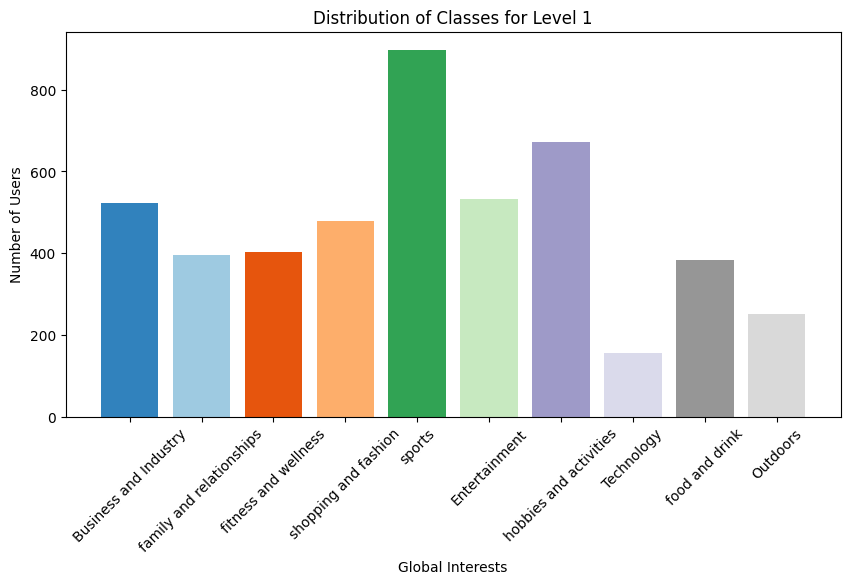

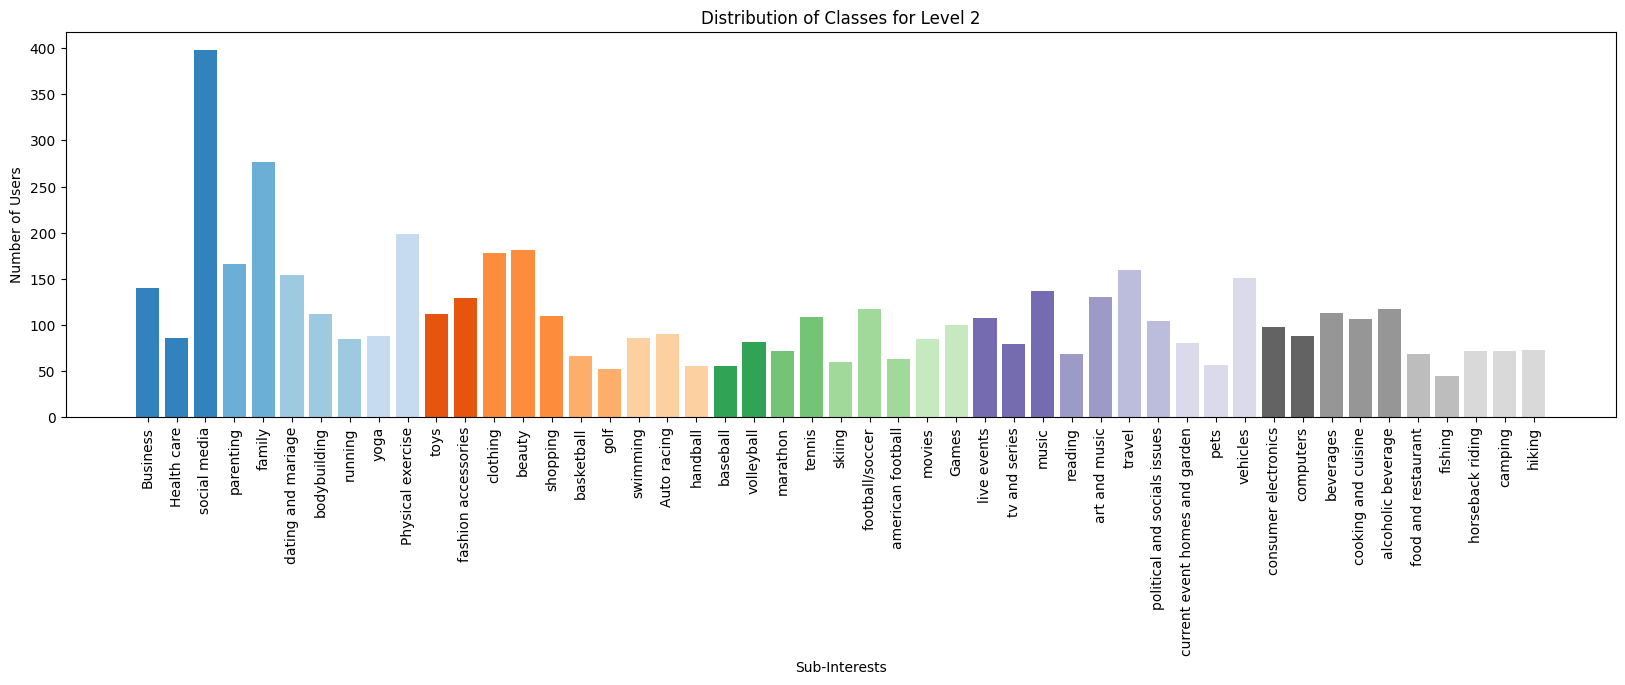

In [21]:
import matplotlib.pyplot as plt

# Plot distribution of classes for Level 1
plt.figure(figsize=(10, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, len(level1_to_int)))
plt.bar(level1_to_int.keys(), np.sum(augmented_Y_level1, axis=0), color=bar_colors)
plt.xlabel('Global Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 1')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of classes for Level 2
plt.figure(figsize=(20, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, len(level2_to_int)))
plt.bar(level2_to_int.keys(), np.sum(augmented_Y_level2, axis=0), color=bar_colors)
plt.xlabel('Sub-Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 2')
plt.xticks(rotation=90)
plt.show()


In [22]:
users[1]['interests']
parent_map = [v for v in level2_to_int.values()]

# Bert Embeddings

In [23]:
pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [24]:
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Assuming X contains preprocessed captions
X_embeddings = []

# Process each preprocessed text and generate BERT embeddings
for text in augmented_X:
    # Tokenize the text
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=256, truncation=True,padding='max_length')
    
    # Convert tokens to PyTorch tensors
    tokens_tensor = torch.tensor([tokens])
    
    # Generate BERT embeddings
    with torch.no_grad():
        attention_mask = (tokens_tensor != tokenizer.pad_token_id).long()
        outputs = model(input_ids=tokens_tensor, attention_mask=attention_mask)
        embeddings = outputs[0]  # BERT embeddings are obtained from the first element of the outputs tuple

    # Append the averaged embeddings to the list
    X_embeddings.append(embeddings)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [25]:
X_embeddings_array = np.concatenate([e.numpy() for e in X_embeddings], axis=0)

# Ensure the shape is correct
# X_embeddings_array should have shape (num_samples, embedding_dim)
print("Shape of X_embeddings_array:", X_embeddings_array.shape)

Shape of X_embeddings_array: (3587, 256, 768)


# Model

In [36]:
# Split data into training, validation, and test sets while preserving class distribution
X_train, X_temp, Y_level1_train, Y_level1_temp, Y_level2_train, Y_level2_temp = train_test_split(
    X_embeddings_array, augmented_Y_level1, augmented_Y_level2, test_size=0.4, random_state=42)

X_val, X_test, Y_level1_val, Y_level1_test, Y_level2_val, Y_level2_test = train_test_split(
    X_temp, Y_level1_temp, Y_level2_temp, test_size=0.5, random_state=42)

In [37]:
def hierarchical_violation_loss(y_true, y_pred, num_level1, parent_map, lambda_val=0.1):
    # Split y_pred into combined_output, concatenated_local_outputs, and global_output
    total_levels = num_level1 + len(parent_map)
    combined_output = y_pred[:, :total_levels]
    concatenated_local_outputs = y_pred[:, total_levels:2 * total_levels]
    global_output = y_pred[:, 2 * total_levels:]
    
    y_pred_level1_local = combined_output[:, :num_level1]
    y_pred_level2_local = combined_output[:, num_level1:]
    
    y_true_level1 = y_true[:, :num_level1]
    y_true_level2 = y_true[:, num_level1:]

    # Hierarchical violation penalty
    violation_penalty = 0
    for i, parent_idx in enumerate(parent_map):
        violation_penalty += tf.reduce_sum(tf.maximum(y_pred_level2_local[:, i] - y_pred_level1_local[:, parent_idx], 0)**2)
    violation_penalty *= lambda_val
    
    # Local loss (LL) using binary_crossentropy
    local_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, concatenated_local_outputs))

    # Global loss (LG) using binary_crossentropy
    global_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, global_output))

    # Total loss
    total_loss = local_loss + global_loss + violation_penalty
    return total_loss


In [38]:
def build_hmcn(input_dim, num_level1, num_level2, neuron_each_local_l2, parent_map, beta=0.5, lambda_val=0.1):
    input_layer = Input(shape=input_dim)
    
    # Apply GlobalAveragePooling1D to reduce the dimensionality
    x = GlobalAveragePooling1D()(input_layer)
    
    # Global Branch
    global_dense_outputs = []
    local_dense_outputs = []

    last_global = x
    for i in range(len(neuron_each_local_l2)):
        if i == 0:
            global_dense = Dense(384, activation='relu')(last_global)
        else:
            global_dense = Dense(384, activation='relu')(Concatenate()([x, last_global]))
        global_dense = LayerNormalization()(global_dense)
        global_dense = Dropout(0.6)(global_dense)
        global_dense_outputs.append(global_dense)
        
        last_global = global_dense

        # Local Branch
        local_dense = Dense(384, activation='relu')(global_dense)
        local_dense_outputs.append(local_dense)
    
    # Local Level 1 and Level 2 Outputs
    local_l1_output = Dense(num_level1, activation='sigmoid')(local_dense_outputs[0])
    local_l2_output = Dense(num_level2, activation='sigmoid')(local_dense_outputs[1])
    
    # Global Outputs
    global_output = Dense(num_level1 + num_level2, activation='sigmoid')(last_global)
    
    # Concatenate local outputs
    concatenated_local_outputs = Concatenate()([local_l1_output, local_l2_output])
    
    # Combine Global and Local Outputs
    combined_output = beta * global_output + (1 - beta) * concatenated_local_outputs
   
    
    # Concatenate all outputs for loss calculation
    all_outputs = Concatenate(axis=1)([combined_output, concatenated_local_outputs, global_output])
        
    #model = Model(inputs=input_layer, outputs=[combined_output, concatenated_local_outputs, global_output])

    model = Model(inputs=input_layer, outputs=all_outputs)
     #model = Model(inputs=input_layer, outputs=combined_output)

     # Custom loss function
    def custom_loss(y_true, y_pred):
        return hierarchical_violation_loss(y_true, y_pred, num_level1, parent_map, lambda_val)
  
  # Custom loss function  
#     def custom_loss(y_true, y_pred):
#         combined_output, concatenated_local_outputs, global_output = y_pred
#         return hierarchical_violation_loss(y_true, combined_output, concatenated_local_outputs, global_output, num_level1, parent_map, lambda_val)
    def multi_label_accuracy(y_true, y_pred):
        total_levels = num_level1 + num_level2
        y_pred = y_pred[:, :total_levels]
        y_pred = K.cast(K.greater(y_pred, 0.5), K.floatx())
        y_true = K.cast(y_true, K.floatx())
        correct_predictions = K.sum(K.cast(K.equal(y_true, y_pred), K.floatx()))
        total_predictions = K.prod(K.cast(K.shape(y_true), K.floatx()))  # Cast to float
        return correct_predictions / total_predictions

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss=custom_loss, 
                  metrics=[multi_label_accuracy])
    return model
    

In [39]:
print(Y_level1_train[600])
print(Y_level2_train[600])

[1 0 1 0 0 0 0 0 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
# Assuming X_train, Y_level1_train, Y_level2_train, X_val, Y_level1_val, Y_level2_val are already defined
input_dim = (X_train.shape[1],X_train.shape[2])
num_level1 = Y_level1_train.shape[1]
num_level2 = Y_level2_train.shape[1]
neuron_each_local_l2 = [384, 384] # Example structure

from tensorflow.keras import backend as K


model = build_hmcn(input_dim, num_level1, num_level2, neuron_each_local_l2, parent_map)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ input_layer_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 384)       │    295,296 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 384)       │        768 │ dense_7[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 384)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1152)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 384)       │    442,752 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 384)       │        768 │ dense_9[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 384)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 384)       │    147,840 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 384)       │    147,840 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │      3,850 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 49)        │     18,865 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 59)        │     22,715 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 59)        │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 59)        │          0 │ dense_13[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 59)        │          0 │ concatenate_4[0]… │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 59)        │          0 │ multiply_2[0][0], │
│                     │                   │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 177)       │          0 │ add_1[0][0],      │
│ (Concatenate)       │                   │            │ concatenate_4[0]… │
│                     │                   │            │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,080,694 (4.12 MB)

 Trainable params: 1,080,694 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Custom F1 score callback
class F1ScoreCallback(Callback):
    def __init__(self, X_val, Y_level1_val, Y_level2_val, num_level1):
        super().__init__()
        self.X_val = X_val
        self.Y_level1_val = Y_level1_val
        self.Y_level2_val = Y_level2_val
        self.num_level1 = num_level1

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = self.model.predict(self.X_val)
        total_levels = self.num_level1 + len(parent_map)
        combined_output = val_predictions[:, :total_levels]
        val_predictions_level1 = combined_output[:, :self.num_level1]
        val_predictions_level2 = combined_output[:, self.num_level1:]
        
        val_predictions_level1 = (val_predictions_level1 > 0.5).astype(int)
        val_predictions_level2 = (val_predictions_level2 > 0.5).astype(int)
        
        f1_level1 = f1_score(self.Y_level1_val, val_predictions_level1, average='micro')
        f1_level2 = f1_score(self.Y_level2_val, val_predictions_level2, average='micro')
        
        print(f'Epoch {epoch + 1}: F1 Score Level 1: {f1_level1:.4f}, F1 Score Level 2: {f1_level2:.4f}')

# Training the model
history = model.fit(
    X_train, 
    np.concatenate([Y_level1_train, Y_level2_train], axis=1), 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, np.concatenate([Y_level1_val, Y_level2_val], axis=1)), 
    callbacks=[F1ScoreCallback(X_val, Y_level1_val, Y_level2_val, num_level1)]
)

Epoch 1/100
15/68 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5027 - multi_label_accuracy: 0.6771

W0000 00:00:1717505451.184856     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 1.6328 - multi_label_accuracy: 0.8244

W0000 00:00:1717505462.150600     150 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717505463.160648     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

W0000 00:00:1717505464.845768     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Epoch 1: F1 Score Level 1: 0.0040, F1 Score Level 2: 0.0000
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - loss: 1.6208 - multi_label_accuracy: 0.8256 - val_loss: 0.3841 - val_multi_label_accuracy: 0.9510
Epoch 2/100
 5/68 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4611 - multi_label_accuracy: 0.9457

W0000 00:00:1717505465.385054     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4358 - multi_label_accuracy: 0
Epoch 2: F1 Score Level 1: 0.0000, F1 Score Level 2: 0.0000
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4346 - multi_label_accuracy: 0.9493 - val_loss: 0.3712 - val_multi_label_accuracy: 0.9517
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4110 - multi_label_accuracy: 0.
Epoch 3: F1 Score Level 1: 0.0000, F1 Score Level 2: 0.0000
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.4107 - multi_label_accuracy: 0.9503 - val_loss: 0.3585 - val_multi_label_accuracy: 0.9517
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3853 - multi_label_accuracy: 0
Epoch 4: F1 Score Level 1: 0.0205, F1 Score Level 2: 0.0000
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.3850 - multi_label_accuracy: 0.9524 - val_loss: 0.3453 - val_multi_label_accuracy: 0.9519
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3617 - multi_label_accuracy: 0
Epoch 5: F1 Score Level 1: 0.0602, F1 S

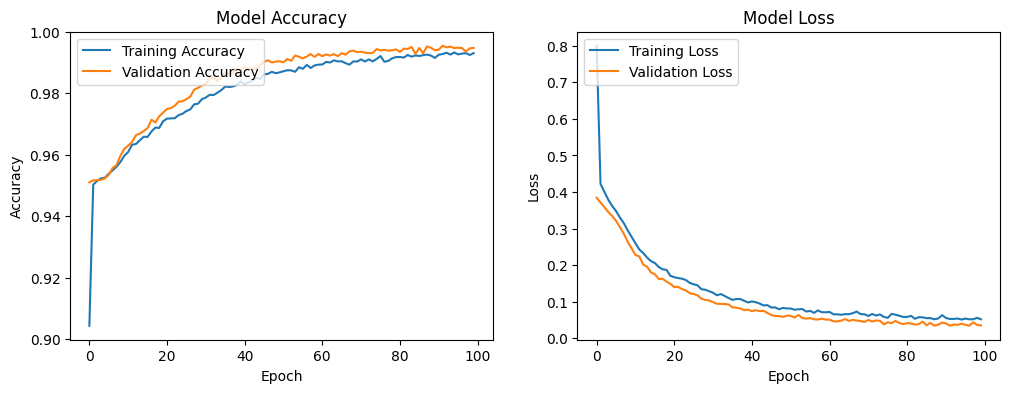

In [42]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['multi_label_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_multi_label_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()



In [ ]:
model.save("/kaggle/working/hmcn-f_model.h5")

In [43]:
# Predictions on Test Set
test_predictions = model.predict(X_test)
total_levels = num_level1 + len(parent_map)
combined_output = test_predictions[:, :total_levels]
test_predictions_level1 = (combined_output[:, :num_level1] > 0.5).astype(int)
test_predictions_level2 = (combined_output[:, num_level1:] > 0.5).astype(int)

# Classification Report
print("Classification Report for Level 1:")
print(classification_report(Y_level1_test, test_predictions_level1, target_names=list(level1_to_int.keys())))
print("\nClassification Report for Level 2:")
print(classification_report(Y_level2_test, test_predictions_level2, target_names=list(level2_to_int.keys())))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Classification Report for Level 1:
                          precision    recall  f1-score   support

   Business and Industry       0.98      0.87      0.92       113
family and relationships       0.99      1.00      0.99        67
    fitness and wellness       0.99      0.97      0.98        80
    shopping and fashion       1.00      0.92      0.96       106
                  sports       0.96      0.99      0.97       173
           Entertainment       0.94      0.97      0.95        98
  hobbies and activities       0.95      1.00      0.97       127
              Technology       0.97      1.00      0.98        31
          food and drink       0.97      1.00      0.99        73
                Outdoors       0.97      1.00      0.98        59

               micro avg       0.97      0.97      0.97       927
               macro avg       0.97      0.97      0.97       927
            weighted avg       0.97      0.97      0.97       927

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


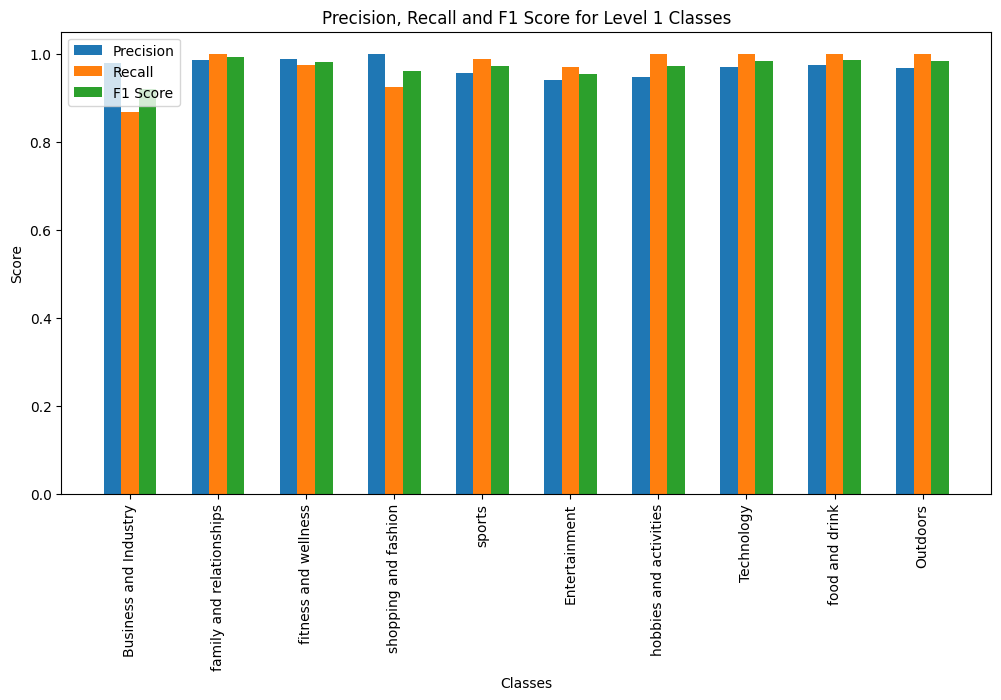

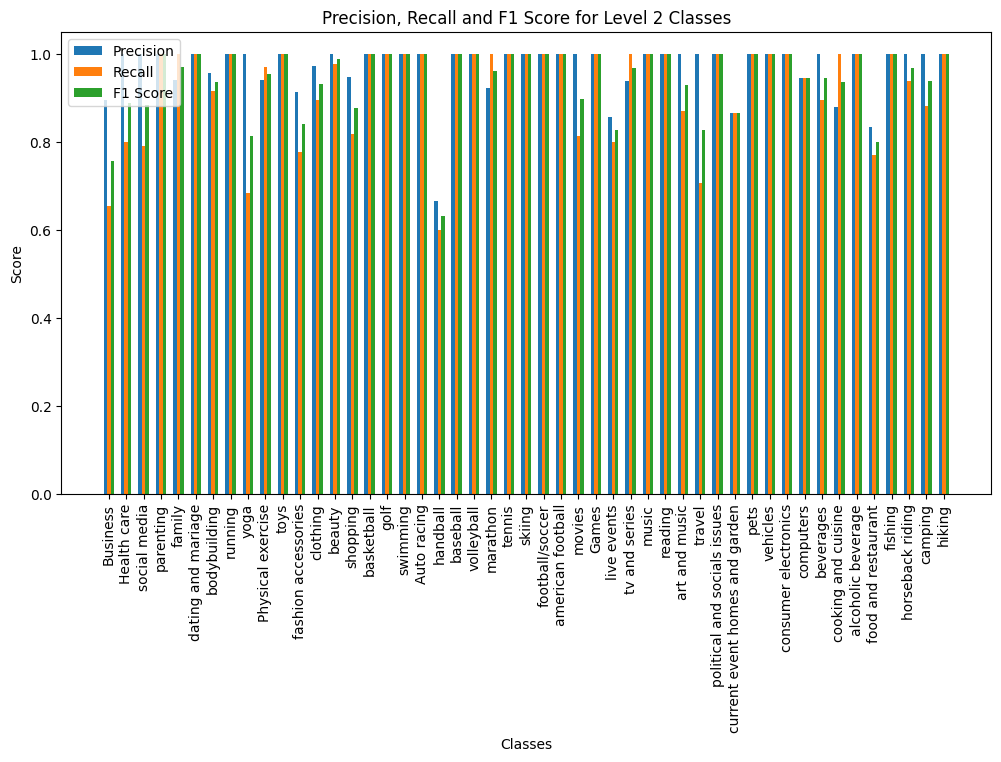

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Plot F1, Precision, and Recall for Level 1
precision_level1 = precision_score(Y_level1_test, test_predictions_level1, average=None)
recall_level1 = recall_score(Y_level1_test, test_predictions_level1, average=None)
f1_level1 = f1_score(Y_level1_test, test_predictions_level1, average=None)

plt.figure(figsize=(12, 6))
x = np.arange(len(level1_to_int))

plt.bar(x - 0.2, precision_level1, 0.2, label='Precision')
plt.bar(x, recall_level1, 0.2, label='Recall')
plt.bar(x + 0.2, f1_level1, 0.2, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 Score for Level 1 Classes')
plt.xticks(x, list(level1_to_int.keys()), rotation='vertical')
plt.legend(loc='upper left')
plt.show()

# Plot F1, Precision, and Recall for Level 2
precision_level2 = precision_score(Y_level2_test, test_predictions_level2, average=None)
recall_level2 = recall_score(Y_level2_test, test_predictions_level2, average=None)
f1_level2 = f1_score(Y_level2_test, test_predictions_level2, average=None)

plt.figure(figsize=(12, 6))
x = np.arange(len(level2_to_int))

plt.bar(x - 0.2, precision_level2, 0.2, label='Precision')
plt.bar(x, recall_level2, 0.2, label='Recall')
plt.bar(x + 0.2, f1_level2, 0.2, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 Score for Level 2 Classes')
plt.xticks(x, list(level2_to_int.keys()), rotation='vertical')
plt.legend(loc='upper left')
plt.show()